# Inspect PlanetesimalAccretion.computeMdotMigration

This notebook reconstructs a single population-synthesis style setup (similar to `run_model_pop_synth.py` and `run_model_discchem_stream.py`) and diagnoses the behaviour of `PlanetesimalAccretion.computeMdotMigration`, focusing on the accretion efficiency `acc_eff_Rp` as a function of time.

In [61]:
# 1. Set up environment and imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

import os, sys, json
import numpy as np
import matplotlib.pyplot as plt

# Ensure we can import the local DiscEvolution package when running from this notebook directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from DiscEvolution.constants import *
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.dust import DustGrowthTwoPop, SingleFluidDrift
from DiscEvolution.viscous_evolution import ViscousEvolutionFV, HybridWindModel, LBP_Solution
from DiscEvolution.diffusion import TracerDiffusion
from DiscEvolution.opacity import Tazzari2016
from DiscEvolution.chemistry import SimpleCOAtomAbund, SimpleCOChemOberg, EquilibriumCOChemOberg, TimeDepCOChemOberg
from DiscEvolution.planet_formation import Planets, Bitsch2015Model, PlanetesimalAccretion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# 2. Load or recreate a single population-synthesis style setup



# Here we hard-code a single configuration close to the defaults in

# example/summer_2025/run_model_pop_synth.py for reproducibility.



config = {

    "grid": {

        "rmin": 1e-1,

        "rmax": 300.0,

        "nr": 400,

        "spacing": "natural",

        "type": "winds-alpha",  # as in the population-synthesis runs

        "smart_binning": True,

    },

    "star": {

        "M": 1.0,

        "R": 2.5,

        "T_eff": 4000.0,

    },

    "disc": {

        "alpha": 1e-3,

        "M": 0.1,      # choose one of the masses used in the synth runs

        "d2g": 0.01,

        "Mdot": 3e-9,   # Msun/yr

        "Sc": 1.0,

        "Rd": 100.0,

        "gamma": 1.0,

    },

    "eos": {

        "type": "IrradiatedEOS",

        "opacity": "Tazzari",

        "h0": 1/30.0,

        "q": -0.25,

    },

    "transport": {

        "gas_transport": True,

        "radial_drift": True,

        "diffusion": True,

        "van_leer": False,

    },

    "dust_growth": {

        "feedback": True,

        "settling": True,

        "f_ice": 1.0,

        "uf_0": 500.0,

        "uf_ice": 500.0,

        "thresh": 0.5,

    },

    "chemistry": {

        "on": False,

        "fix_mu": True,

        "mu": 2.5,

        "chem_model": "Equilibrium",

        "assert_d2g": True,

    },

    "planetesimal": {

        "active": True,

        "diameter": 200.0,

        "St_min": 1e-2,

        "St_max": 10.0,

        "pla_eff": 0.05,

    },

    "winds": {

        "on": True,

        "psi_DW": 100.0,

        "e_rad": 0.9,

    },

    "planets": {

        "include_planets": True,

        "Rp0": 5.0,       # initial radius (AU) for the test planet

        "Mp0": 1e-2,      # initial planet mass (Earth masses)

        "implant_time": 0.0,

        "pb_gas_f": 0.05,

        "migrate": True,

        "pebble_accretion": True,

        "gas_accretion": True,

        "planetesimal_accretion": True,

    },

}



params_run = {

    "Rp0": config["planets"]["Rp0"],

    "Mp0": config["planets"]["Mp0"],

    "disc_M": config["disc"]["M"],

    "disc_Mdot": config["disc"]["Mdot"],

    "psi_DW": config["winds"]["psi_DW"],

}



params_run

{'Rp0': 5.0, 'Mp0': 0.01, 'disc_M': 0.1, 'disc_Mdot': 3e-09, 'psi_DW': 100.0}

In [63]:
# 3. Construct disc and planet-formation components (mirroring run_model_pop_synth)

def build_disc_and_planet_model(cfg):
    grid_params = cfg["grid"]
    star_params = cfg["star"]
    disc_params = cfg["disc"]
    eos_params = cfg["eos"]
    transport_params = cfg["transport"]
    dust_growth_params = cfg["dust_growth"]
    chem_params = cfg["chemistry"]
    pla_params = cfg["planetesimal"]
    wind_params = cfg["winds"]
    planet_params = cfg["planets"]

    # Grid and star
    grid = Grid(grid_params["rmin"], grid_params["rmax"], grid_params["nr"], spacing=grid_params["spacing"])
    star = SimpleStar(M=star_params["M"], R=star_params["R"], T_eff=star_params["T_eff"])

    # Opacity
    kappa = Tazzari2016() if eos_params["opacity"] == "Tazzari" else None

    # For this diagnostic, reuse the winds-alpha branch from run_model_pop_synth
    R = grid.Rc
    psi = wind_params["psi_DW"]
    Rd = disc_params["Rd"]
    alpha = disc_params["alpha"]
    Mdisk = disc_params["M"] * Msun
    e_rad = wind_params["e_rad"]
    gamma = disc_params["gamma"]

    lambda_DW = 1.0 / (2.0 * (1.0 - e_rad) * (3.0 / psi + 1.0)) + 1.0
    alpha_SS = alpha / (1.0 + psi)

    # Initial guess for Sigma (cf. winds-alpha branch)
    Sigma_d = Mdisk / (2.0 * np.pi * (Rd * AU) ** 2)
    xi = 0.0
    Sigma = Sigma_d * (R / Rd) ** (xi - gamma) * np.exp(-(R / Rd) ** (2.0 - gamma))

    # Initial disc and gas model
    disc = AccretionDisc(grid, star, eos=None, Sigma=Sigma)
    gas_temp = HybridWindModel(psi, lambda_DW)
    Mtot = disc.Mtot()
    Sigma[:] *= Mdisk / Mtot

    # Iterate a few times to get a self-consistent eos + Sigma + alpha_SS
    for _ in range(20):
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params["h0"], eos_params["q"], alpha_SS)
        else:
            eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad)

        eos.set_grid(grid)
        eos.update(0.0, Sigma)
        disc = AccretionDisc(grid, star, eos, Sigma)

        vr = gas_temp.viscous_velocity(disc, Sigma)
        Mdot_actual = disc.Mdot(vr)[0]

        # Scale alpha and alpha_SS to match target Mdot
        Mdot_target = disc_params["Mdot"]  # Msun / yr
        alpha_new = alpha * Mdot_target / Mdot_actual
        alpha = 0.5 * (alpha + alpha_new)
        alpha_SS = alpha / (1.0 + psi)

    # Final disc with DustGrowthTwoPop
    disc = DustGrowthTwoPop(
        grid,
        star,
        eos,
        disc_params["d2g"],
        Sigma=Sigma,
        feedback=dust_growth_params["feedback"],
        Sc=disc_params["Sc"],
        f_ice=dust_growth_params["f_ice"],
        thresh=dust_growth_params["thresh"],
        uf_0=dust_growth_params["uf_0"],
        uf_ice=dust_growth_params["uf_ice"],
        gas=gas_temp,
    )

    # Build diffusion and dust transport (for CFL + evolution)
    diffuse = None
    if transport_params["diffusion"]:
        diffuse = TracerDiffusion(Sc=disc_params["Sc"])
    dust_model = None
    if transport_params["radial_drift"]:
        dust_model = SingleFluidDrift(
            diffusion=diffuse,
            settling=dust_growth_params["settling"],
            van_leer=transport_params["van_leer"],
        )
        # Mirror run_model_pop_synth behaviour: explicit tracer diffusion only when no radial drift
        diffuse_for_loop = None
    else:
        diffuse_for_loop = diffuse

    # Chemistry (simple equilibrium CO chemistry, mirroring run_model_pop_synth)
    chemistry_model = None
    if chem_params["on"]:
        N_cell = grid_params["nr"]
        if chem_params["chem_model"] == "Simple":
            chemistry_model = SimpleCOChemOberg()
        elif chem_params["chem_model"] == "Equilibrium":
            chemistry_model = EquilibriumCOChemOberg(fix_ratios=False, a=1e-5)
        else:
            chemistry_model = TimeDepCOChemOberg(a=1e-5)

        X_solar = SimpleCOAtomAbund(N_cell)
        X_solar.set_solar_abundances()

        for _ in range(20):
            if chem_params["assert_d2g"]:
                M_dust = np.trapz(disc.Sigma_D.sum(0), np.pi * grid.Rc ** 2)
                M_gas = np.trapz(disc.Sigma_G, np.pi * grid.Rc ** 2)
                mod_frac = disc_params["d2g"] / (M_dust / M_gas)
                disc.dust_frac[:] = disc.dust_frac * mod_frac

            if disc._planetesimal:
                dust_frac = disc.dust_frac[:-1].sum(0)
            else:
                dust_frac = disc.dust_frac.sum(0)

            chem = chemistry_model.equilibrium_chem(disc.T, disc.midplane_gas_density, dust_frac, X_solar)
            disc.initialize_dust_density(chem.ice.total_abund)

        disc.chem = chem
        disc.update_ices(disc.chem.ice)

    # Ensure disc.chem exists even if chemistry is disabled
    if not hasattr(disc, "chem"):
        disc.chem = None

    # Planetesimals
    from DiscEvolution.dust import PlanetesimalFormation
    disc._planetesimal = None
    if pla_params["active"]:
        disc._planetesimal = PlanetesimalFormation(
            disc,
            d_planetesimal=pla_params["diameter"],
            St_min=pla_params["St_min"],
            St_max=pla_params["St_max"],
            pla_eff=pla_params["pla_eff"],
        )

    # Planet formation model with planetesimal accretion enabled
    planets = Planets(Nchem=0)
    Rp0 = planet_params["Rp0"]
    Mp0 = planet_params["Mp0"]
    planets.add_planet(planet_params["implant_time"], Rp0, Mp0, 0.0)

    planet_model = Bitsch2015Model(
        disc,
        pb_gas_f=planet_params["pb_gas_f"],
        migrate=planet_params["migrate"],
        pebble_acc=planet_params["pebble_accretion"],
        gas_acc=planet_params["gas_accretion"],
        planetesimal_acc=planet_params["planetesimal_accretion"],
        winds=wind_params["on"],
    )
    planet_model.set_disc(disc)

    # Sanity checks
    print("Disc total mass (Msun):", disc.Mtot() / Msun)
    print("Dust-to-gas (global):", (disc.Sigma_D.sum(0) / disc.Sigma_G).mean())
    print("Planetesimal component present:", disc._planetesimal is not None)
    print("Planetesimal accretion model present:", isinstance(planet_model._pl_acc, PlanetesimalAccretion))
    print("Initial planet R (AU), M (M_earth):", planets.R, planets.M)

    return disc, planet_model, planets, gas_temp, dust_model, diffuse_for_loop, chemistry_model, lambda_DW

disc, planet_model, planets, gas_model, dust_model, diffuse_model, chemistry_model, lambda_DW = build_disc_and_planet_model(config)

Disc total mass (Msun): 0.10000000000000002
Dust-to-gas (global): 0.0101010101010101
Planetesimal component present: True
Planetesimal accretion model present: True
Initial planet R (AU), M (M_earth): [5.] [0.01]


In [64]:
# 4. Diagnostics wrapper around PlanetesimalAccretion

def diagnostics_planetesimal(pl_acc, Rp, Mp, dRdt):
    """Return a dict of diagnostic quantities for planetesimal accretion.

    Parameters
    ----------
    pl_acc : PlanetesimalAccretion
    Rp : array-like, AU
    Mp : array-like, M_earth
    dRdt : array-like, AU / code time unit
    """
    # Use the model's own efficiency + capture radius
    acc_eff, R_captr_norm = pl_acc.computeAccEff(Rp, Mp, dRdt)

    disc = pl_acc._disc
    star = disc.star

    # Hill radius and aspect ratio
    rH = star.r_Hill(Rp, Mp * Mearth / Msun)
    h_p = rH / Rp

    # Normalized inclination i0 (eq. 10 in Danti et al. via inclination()/h_p)
    i0_norm = pl_acc.inclination(Rp) / h_p

    # Orbital period (code units, 1 yr ≈ 2π)
    T_k = (2.0 * np.pi) / star.Omega_k(Rp)

    # Normalized migration timescale τ_mig (eq. B.4)
    tau_mig = Rp / np.maximum(np.abs(dRdt), 1e-30) * (h_p**2 / T_k)

    # Alpha and beta parameters (eq. B.3/B.5 form)
    alpha_pla = 2.5 * np.sqrt(R_captr_norm / (1.0 + 0.37 * i0_norm**2 / R_captr_norm))
    beta_pla = 0.79 * (1.0 + 10.0 * i0_norm**2) ** (-0.17)

    return {
        "acc_eff_Rp": np.array(acc_eff, copy=True),
        "R_captr": np.array(R_captr_norm, copy=True),  # already normalized by rH
        "rH": np.array(rH, copy=True),
        "tau_mig": np.array(tau_mig, copy=True),
        "i0_norm": np.array(i0_norm, copy=True),
        "alpha_pla": np.array(alpha_pla, copy=True),
        "beta_pla": np.array(beta_pla, copy=True),
    }

# Quick sanity check at t=0
pl_acc = planet_model._pl_acc
from DiscEvolution.planet_formation import PlanetMigration

dRdt0 = planet_model._migrate.migration_rate(planets.R, planets.M)
diag0 = diagnostics_planetesimal(pl_acc, planets.R, planets.M, dRdt0)
diag0

{'acc_eff_Rp': array([0.00580745]),
 'R_captr': array([0.00135782]),
 'rH': array([0.01077518]),
 'tau_mig': array([8.67378041]),
 'i0_norm': array([4.0780085]),
 'alpha_pla': array([0.00136831]),
 'beta_pla': array([0.33085074])}

In [65]:
# 5. Time-integrate a single run and record acc_eff_Rp and related quantities

def integrate_with_planetesimals(cfg, disc, planet_model, planets, gas_model=None, dust_model=None, diffuse=None, chemistry_model=None, t_end_yr=3e6, max_steps=200000):
    """Integrate disc + planet evolution and record planetesimal accretion diagnostics.

    The timestep follows the same Courant-style condition as run_model_pop_synth:
    dt is limited by gas and dust max_timestep(disc), and the disc, dust,
    planetesimals, chemistry (optional), and planets are all evolved each step.
    """
    transport_params = cfg["transport"]
    chem_params = cfg["chemistry"]
    chem_on = chem_params["on"]

    pl_acc = planet_model._pl_acc
    mig = planet_model._migrate

    t_end_code = t_end_yr * (2.0 * np.pi)  # code units
    t = 0.0
    step = 0

    times_hist = []
    acc_eff_hist = []
    R_hist = []
    M_hist = []
    dRdt_hist = []
    Rcap_hist = []
    tau_hist = []
    rH_hist = []
    i0_hist = []
    alpha_hist = []
    beta_hist = []

    while t < t_end_code and step < max_steps:
        # Base on remaining time, then apply CFL from gas and dust
        dt = t_end_code - t
        if transport_params["gas_transport"] and gas_model is not None:
            dt = min(dt, gas_model.max_timestep(disc))
        if transport_params["radial_drift"] and dust_model is not None:
            dt = min(dt, dust_model.max_timestep(disc))
        if dt <= 0:
            break

        # Extract dust fraction
        dust_frac = None
        try:
            dust_frac = disc.dust_frac
        except AttributeError:
            pass

        # Extract gas tracers (chemistry)
        gas_chem, ice_chem = None, None
        if chem_on and chemistry_model is not None and hasattr(disc, "chem"):
            gas_chem = disc.chem.gas.data
            ice_chem = disc.chem.ice.data

        # Gas evolution
        if transport_params["gas_transport"] and gas_model is not None:
            if disc._planetesimal is not None:
                gas_model(dt, disc, [dust_frac[:-1], gas_chem, ice_chem])
            else:
                gas_model(dt, disc, [dust_frac, gas_chem, ice_chem])

        # Dust evolution
        if transport_params["radial_drift"] and dust_model is not None:
            if disc._planetesimal is not None:
                dust_model(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)
            else:
                dust_model(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)

        # Optional explicit tracer diffusion (only when diffuse is not None)
        if diffuse is not None:
            if gas_chem is not None:
                gas_chem[:] += dt * diffuse(disc, gas_chem)
            if ice_chem is not None:
                ice_chem[:] += dt * diffuse(disc, ice_chem)
            if dust_frac is not None:
                if disc._planetesimal is not None:
                    dust_frac[:-1] += dt * diffuse(disc, dust_frac[:-1])
                else:
                    dust_frac[:] += dt * diffuse(disc, dust_frac[:])

        # Clamp and renormalize
        disc.Sigma[:] = np.maximum(disc.Sigma, 0)
        disc.dust_frac[:] = np.maximum(disc.dust_frac, 0)
        disc.dust_frac[:] /= np.maximum(disc.dust_frac.sum(0), 1.0)
        if chem_on and hasattr(disc, "chem"):
            disc.chem.gas.data[:] = np.maximum(disc.chem.gas.data, 0)
            disc.chem.ice.data[:] = np.maximum(disc.chem.ice.data, 0)

        # Planetesimal update
        if disc._planetesimal is not None:
            disc._planetesimal.update(dt, disc, dust_model)

        # Chemistry update
        if chem_on and chemistry_model is not None and hasattr(disc, "chem"):
            if disc._planetesimal is not None:
                chemistry_model.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac[:-1].sum(0), disc.chem)
            else:
                chemistry_model.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac.sum(0), disc.chem)
            disc.update_ices(disc.chem.ice)

        # Planet evolution (includes migration + accretion)
        planet_model.integrate(dt, planets)

        # Disc bookkeeping
        disc.update(dt)

        # Diagnostics: current migration rate and planetesimal accretion
        dRdt = mig.migration_rate(planets.R, planets.M)
        diag = diagnostics_planetesimal(pl_acc, planets.R, planets.M, dRdt)

        t_new = t + dt
        times_hist.append(t_new)
        acc_eff_hist.append(diag["acc_eff_Rp"].copy())
        R_hist.append(planets.R.copy())
        M_hist.append(planets.M.copy())
        dRdt_hist.append(dRdt.copy())
        Rcap_hist.append(diag["R_captr"].copy())
        tau_hist.append(diag["tau_mig"].copy())
        rH_hist.append(diag["rH"].copy())
        i0_hist.append(diag["i0_norm"].copy())
        alpha_hist.append(diag["alpha_pla"].copy())
        beta_hist.append(diag["beta_pla"].copy())

        t = t_new
        step += 1

    return {
        "t_code": np.array(times_hist),
        "t_yr": np.array(times_hist) / (2.0 * np.pi),
        "acc_eff_Rp": np.array(acc_eff_hist),
        "R": np.array(R_hist),
        "M": np.array(M_hist),
        "dRdt": np.array(dRdt_hist),
        "R_captr": np.array(Rcap_hist),
        "tau_mig": np.array(tau_hist),
        "rH": np.array(rH_hist),
        "i0_norm": np.array(i0_hist),
        "alpha_pla": np.array(alpha_hist),
        "beta_pla": np.array(beta_hist),
    }

diag_run = integrate_with_planetesimals(
    config,
    disc,
    planet_model,
    planets,
    gas_model=gas_model,
    dust_model=dust_model,
    diffuse=diffuse_model,
    chemistry_model=chemistry_model,
    t_end_yr=1e6,
 )
diag_run["t_yr"][:5], diag_run["acc_eff_Rp"][:5]

/Users/mbalogh/projects/PlanetFormation/python/DiscEvolution/DiscEvolution/dust.py:452: RuntimeWarning: overflow encountered in exp
  amax = np.minimum(a0, a*np.exp(dt/t_grow))  # If dust grains start small (default) first have to grow)


(array([1276.68452104, 1282.13643744, 1287.57795667, 1292.96654811,
        1298.29512126]),
 array([[0.00581714],
        [0.00581821],
        [0.00581673],
        [0.00581675],
        [0.00581678]]))

Final acc_eff_Rp: 1.0
Final tau_mig: 1425.598914623956
Final rH: 0.003952063342074924
Final R_captr (normalized): 0.21942043790269067
Final i0_norm: 0.002328486351931419
Final alpha_pla: 1.1710530299612174
Final beta_pla: 0.7899927186881535


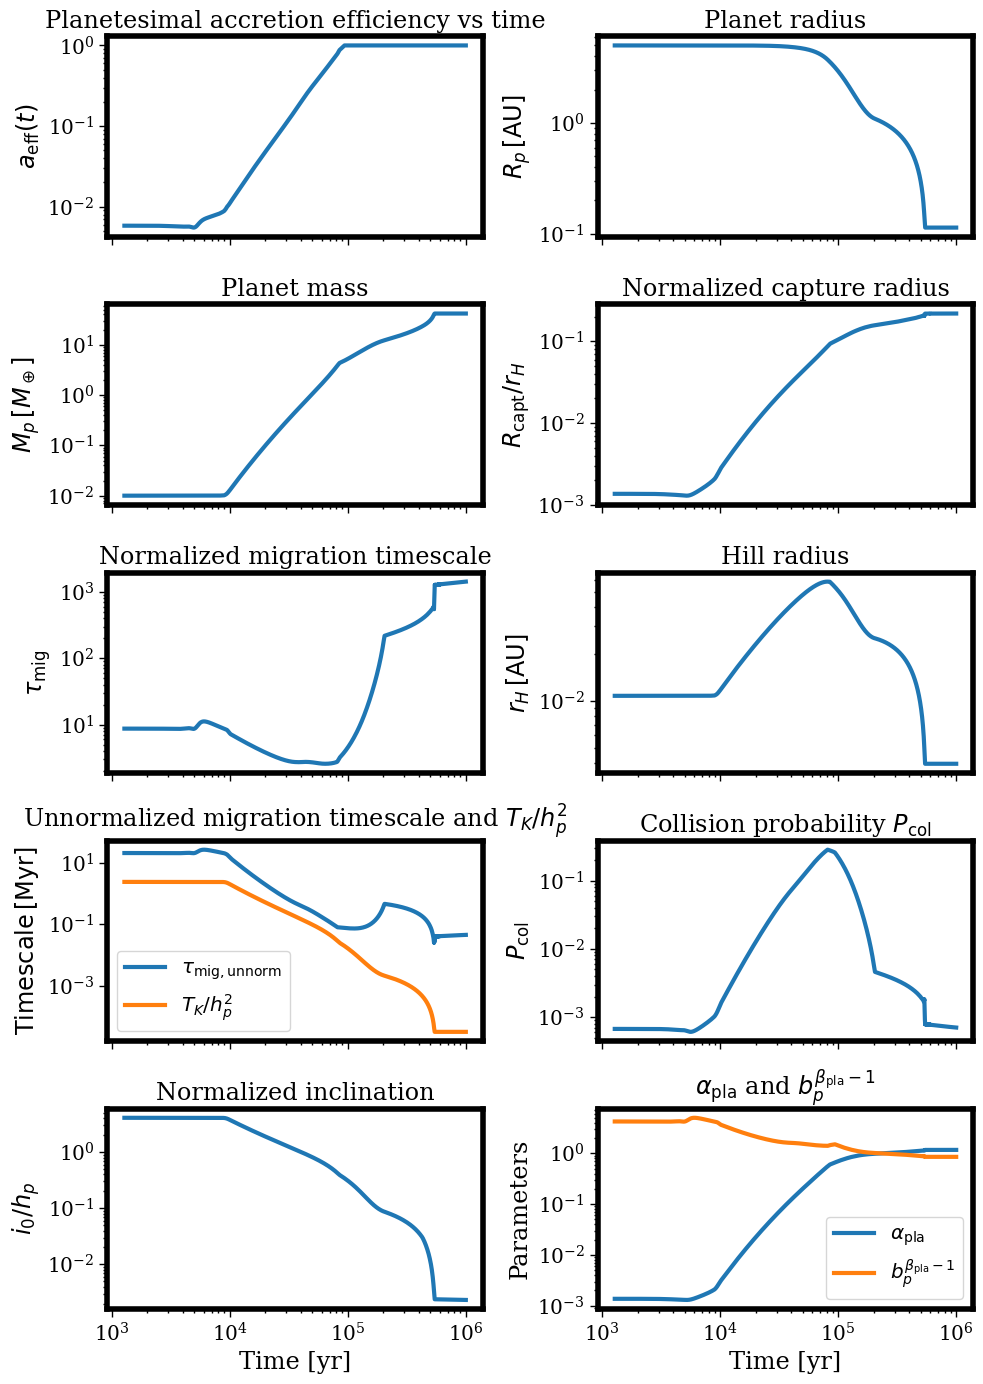

In [66]:
# 6. Plot acc_eff_Rp and all input quantities vs time


def plot_diagnostics(diag):
    t_yr = diag["t_yr"]


    acc_eff = diag["acc_eff_Rp"][:, 0]  # single planet index 0
    R = diag["R"][:, 0]
    M = diag["M"][:, 0]
    R_cap = diag["R_captr"][:, 0]
    tau_mig = diag["tau_mig"][:, 0]
    rH = diag["rH"][:, 0]
    i0 = diag["i0_norm"][:, 0]
    alpha_pla = diag["alpha_pla"][:, 0]
    beta_pla = diag["beta_pla"][:, 0]
    dRdt = diag["dRdt"][:, 0]


    # Unnormalized migration timescale in Myr
    # Rp / |dRdt| gives a timescale in code units; convert to Myr.
    tau_un_code = R / np.maximum(np.abs(dRdt), 1e-30)
    tau_un_Myr = tau_un_code / ((2.0 * np.pi) * 1e6)

    # Inverse normalization factor T_K / h_p^2, also in Myr.
    # From tau_mig = (Rp/|dRdt|) * (h_p^2 / T_K) => T_K/h_p^2 = (Rp/|dRdt|) / tau_mig.
    TK_over_hp2_code = tau_un_code / np.maximum(tau_mig, 1e-30)
    TK_over_hp2_Myr = TK_over_hp2_code / ((2.0 * np.pi) * 1e6)

    # b_p^(beta_pla - 1); in the model this equals acc_eff / alpha_pla
    bp_pow = acc_eff / np.maximum(alpha_pla, 1e-30)

    # Collision probability P_col = alpha_pla * b_p^beta_pla = acc_eff / tau_mig
    P_col = acc_eff / np.maximum(tau_mig, 1e-30)


    fig, axes = plt.subplots(5, 2, figsize=(10, 14), sharex=True)


    # Row 0: efficiency and radius
    ax = axes[0, 0]
    ax.loglog(t_yr, acc_eff)
    ax.set_ylabel(r"$a_\mathrm{eff}(t)$")
    ax.set_title("Planetesimal accretion efficiency vs time")


    ax = axes[0, 1]
    ax.loglog(t_yr, R)
    ax.set_ylabel(r"$R_p\, [\mathrm{AU}]$")
    ax.set_title("Planet radius")


    # Row 1: mass and normalized capture radius
    ax = axes[1, 0]
    ax.loglog(t_yr, M)
    ax.set_ylabel(r"$M_p\, [M_\oplus]$")
    ax.set_title("Planet mass")


    ax = axes[1, 1]
    ax.loglog(t_yr, R_cap)
    ax.set_ylabel(r"$R_\mathrm{capt}/r_H$")
    ax.set_title("Normalized capture radius")


    # Row 2: normalized tau_mig and Hill radius
    ax = axes[2, 0]
    ax.loglog(t_yr, tau_mig)
    ax.set_ylabel(r"$\tau_\mathrm{mig}$")
    ax.set_title("Normalized migration timescale")


    ax = axes[2, 1]
    ax.loglog(t_yr, rH)
    ax.set_ylabel(r"$r_H\, [\mathrm{AU}]$")
    ax.set_title("Hill radius")


    # Row 3: unnormalized migration timescale in Myr and T_K/h_p^2
    ax = axes[3, 0]
    ax.loglog(t_yr, tau_un_Myr, label=r"$\tau_\mathrm{mig,unnorm}$")
    ax.loglog(t_yr, TK_over_hp2_Myr, label=r"$T_K/h_p^2$")
    ax.set_ylabel(r"$\mathrm{Timescale}\,[\mathrm{Myr}]$")
    ax.set_title("Unnormalized migration timescale and $T_K/h_p^2$")
    ax.legend()


    # Row 3 right: collision probability P_col
    ax = axes[3, 1]
    ax.loglog(t_yr, P_col)
    ax.set_ylabel(r"$P_\mathrm{col}$")
    ax.set_title(r"Collision probability $P_\mathrm{col}$")


    # Row 4: normalized inclination, alpha_pla, b_p^(beta_pla - 1)
    ax = axes[4, 0]
    ax.loglog(t_yr, i0)
    ax.set_ylabel(r"$i_0/h_p$")
    ax.set_title("Normalized inclination")


    ax = axes[4, 1]
    ax.loglog(t_yr, alpha_pla, label=r"$\alpha_\mathrm{pla}$")
    ax.loglog(t_yr, bp_pow, label=r"$b_p^{\beta_\mathrm{pla}-1}$")
    ax.set_ylabel("Parameters")
    ax.set_title(r"$\alpha_\mathrm{pla}$ and $b_p^{\beta_\mathrm{pla}-1}$")
    ax.legend()


    for ax in axes[-1, :]:
        ax.set_xlabel("Time [yr]")


    fig.tight_layout()
    return fig


# Make plots and also print final values of key quantities
_ = plot_diagnostics(diag_run)


last = -1
print("Final acc_eff_Rp:", diag_run["acc_eff_Rp"][last, 0])
print("Final tau_mig:", diag_run["tau_mig"][last, 0])
print("Final rH:", diag_run["rH"][last, 0])
print("Final R_captr (normalized):", diag_run["R_captr"][last, 0])
print("Final i0_norm:", diag_run["i0_norm"][last, 0])
print("Final alpha_pla:", diag_run["alpha_pla"][last, 0])
print("Final beta_pla:", diag_run["beta_pla"][last, 0])

In [ ]:
# 7. Optional: simple parameter scan utility

def run_parameter_scan(Rp0_list=(1.0, 5.0, 10.0), Mp0=1e-2):
    curves = []
    for Rp0 in Rp0_list:
        cfg = json.loads(json.dumps(config))  # shallow copy via JSON
        cfg["planets"]["Rp0"] = float(Rp0)
        cfg["planets"]["Mp0"] = float(Mp0)

        disc_i, pm_i, planets_i, gas_i, dust_i, diff_i, chem_i, lambda_i = build_disc_and_planet_model(cfg)
        diag_i = integrate_with_planetesimals(
            cfg,
            disc_i,
            pm_i,
            planets_i,
            gas_model=gas_i,
            dust_model=dust_i,
            diffuse=diff_i,
            chemistry_model=chem_i,
            t_end_yr=1e6,
        )
        curves.append((Rp0, diag_i))
    return curves

def plot_scan(curves):
    plt.figure(figsize=(7, 5))
    for Rp0, diag_i in curves:
        t_yr = diag_i["t_yr"]
        acc_eff = diag_i["acc_eff_Rp"][:, 0]
        plt.loglog(t_yr, acc_eff, label=f"R0={Rp0} AU")
    plt.xlabel("Time [yr]")
    plt.ylabel(r"$a_\mathrm{eff}(t)$")
    plt.legend()
    plt.title("acc_eff_Rp vs time for different initial radii")
    plt.tight_layout()

# Example: comment/uncomment to run a small scan
# curves = run_parameter_scan(Rp0_list=(1.0, 5.0, 10.0), Mp0=config["planets"]["Mp0"])
# plot_scan(curves)

In [60]:
# Quick test: verify acc_eff is capped at 1

# FORCE REIMPORT to pick up code changes
import importlib
import DiscEvolution.planet_formation
importlib.reload(DiscEvolution.planet_formation)

# Rebuild the planet model to get fresh pl_acc object with updated code
print("Rebuilding planet model to pick up code changes...")
disc, planet_model, planets, gas_model, dust_model, diffuse_model, chemistry_model, lambda_DW = build_disc_and_planet_model(config)
pl_acc = planet_model._pl_acc
print("Done.\n")

# Test with slow migration (long timescales) which should trigger high acc_eff
test_masses = np.array([0.1, 1.0, 10.0, 100.0])  # M_earth
test_radii = np.array([0.1, 1.0, 5.0, 10.0, 20.0, 30.0])  # AU

# Very slow migration = large tau_mig = small b_p = potentially large acc_eff
test_dRdt = -0.00001  # AU / code time unit (slow migration)

print("Testing acc_eff calculation with VERY SLOW migration:")
print("(slow migration → large τ_mig → small b_p → can make acc_eff large)")
print("=" * 80)

max_acc_eff = 0.0
violations = []

for Mp in test_masses:
    for Rp in test_radii:
        acc_eff, R_captr = pl_acc.computeAccEff(np.array([Rp]), np.array([Mp]), np.array([test_dRdt]))
        
        status = "✓ OK" if acc_eff[0] <= 1.0 else "❌ EXCEEDS 1.0"
        print(f"{status:15s} Rp={Rp:5.1f} AU, Mp={Mp:6.1f} M⊕, dRdt={test_dRdt:.5f} → acc_eff={acc_eff[0]:8.5f}")
        
        max_acc_eff = max(max_acc_eff, acc_eff[0])
        
        if acc_eff[0] > 1.0:
            violations.append((Rp, Mp, acc_eff[0]))

print("\n" + "=" * 80)
print(f"Max acc_eff from all tests: {max_acc_eff:.6f}")
if violations:
    print(f"\n⚠️  FOUND {len(violations)} VIOLATIONS where acc_eff > 1.0:")
    for Rp, Mp, aeff in violations[:5]:  # show first 5
        print(f"  Rp={Rp} AU, Mp={Mp} M⊕ → acc_eff={aeff:.6f}")
    print("\n🔴 CAP IS NOT WORKING - code change not applied!")
else:
    print("\n✅ SUCCESS - all acc_eff values ≤ 1.0, cap is working!")
print("=" * 80)

Rebuilding planet model to pick up code changes...
Disc total mass (Msun): 0.10000000000000002
Dust-to-gas (global): 0.0101010101010101
Planetesimal component present: True
Planetesimal accretion model present: False
Initial planet R (AU), M (M_earth): [5.] [0.01]
Done.

Testing acc_eff calculation with VERY SLOW migration:
(slow migration → large τ_mig → small b_p → can make acc_eff large)
✓ OK            Rp=  0.1 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.33176
✓ OK            Rp=  1.0 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.02388
✓ OK            Rp=  5.0 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.00477
✓ OK            Rp= 10.0 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.00116
✓ OK            Rp= 20.0 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.00022
✓ OK            Rp= 30.0 AU, Mp=   0.1 M⊕, dRdt=-0.00001 → acc_eff= 0.00008
✓ OK            Rp=  0.1 AU, Mp=   1.0 M⊕, dRdt=-0.00001 → acc_eff= 0.90541
✓ OK            Rp=  1.0 AU, Mp=   1.0 M⊕, dRdt=-0.00001 → acc_eff= 0.2657